In [1]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn, morris
from scipy.signal import correlate
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import numpy as np
import seaborn as sns
from ripser import ripser
import pandas as pd
import pickle
import time
import os
from scipy import signal as sp_signal
from scipy.stats import binned_statistic_2d
from scipy.stats import gaussian_kde
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

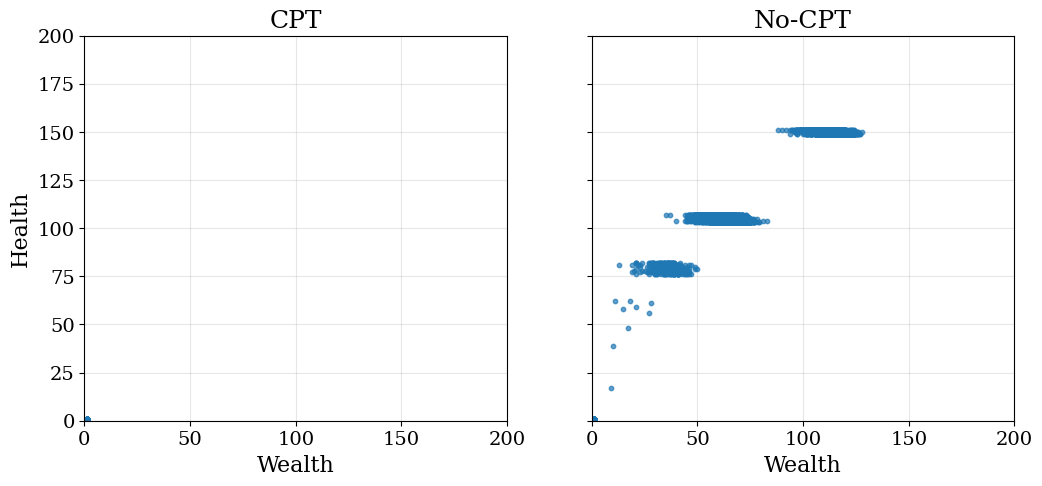

In [139]:
IDX = 541

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for idx, d in enumerate(["results_5/", "cpt_no_effect/"]):
    for i, file in enumerate(sorted(os.listdir(d))):
        if i == IDX:
            with open(d+file, "rb") as f:
                res = pickle.load(f)
            P = res["policy"]
            break        
    axs[idx].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=10,
        alpha=0.7
    )
    axs[idx].set_xlim(0,200)
    axs[idx].set_ylim(0,200)
    axs[idx].grid()

axs[0].set_title("CPT")
axs[1].set_title("No-CPT")
axs[0].set_ylabel("Health")
axs[0].set_xlabel("Wealth")
axs[1].set_xlabel("Wealth")
plt.show()

In [159]:
A = res["params"]["w_delta_scale"]
alpha = res["params"]["alpha"]
P_H_decrease = res["params"]["P_H_decrease"]
P_H_increase = res["params"]["P_H_increase"]

w_init = 100
h_init = 100

cpt_agent = (w_init, h_init)
cpt_util = [utility(w_init, h_init, alpha)]
cpt_pos = []

nocpt_agent = (w_init, h_init)
nocpt_util = [utility(w_init, h_init, alpha)]
nocpt_pos = []

num_steps = 5000

for s in tqdm(range(num_steps)):

    RN = np.random.uniform(0,1,1)

    # CPT
    w, h = cpt_agent
    w = int(w)
    h = int(h)
    cpt_decision = cpt_P[w-1, h-1]
    invest_cost = compute_health_cost(h)
    health_delta = compute_health_delta(h)

    if cpt_decision == 1 and w > invest_cost:
        new_w = compute_new_wealth(w-invest_cost, A, utility(w-invest_cost, h, alpha))
        new_h = h
        if RN < P_H_increase:
            new_h = min(h + health_delta, 200)
        cpt_agent = (new_w, new_h)
        cpt_util.append(utility(new_w, new_h, alpha))
        cpt_pos.append(cpt_agent)
    else:
        new_w = compute_new_wealth(w, A, utility(w, h, alpha))
        new_h = h
        if RN < P_H_decrease:
            new_h = max(1, h - health_delta)
        cpt_agent = (int(new_w), int(new_h))
        cpt_util.append(utility(new_w, new_h, alpha))
        cpt_pos.append(cpt_agent)
            
    # No CPT
    w, h = nocpt_agent
    w = int(w)
    h = int(h)
    nocpt_decision = nocpt_P[w-1, h-1]
    invest_cost = compute_health_cost(h)
    health_delta = compute_health_delta(h)

    if nocpt_decision == 1 and w > invest_cost:
        new_w = compute_new_wealth(w-invest_cost, A, utility(w-invest_cost, h, alpha))
        new_h = h
        if RN < P_H_increase:
            new_h = min(h + health_delta, 200)
        nocpt_agent = (new_w, new_h)
        nocpt_util.append(utility(new_w, new_h, alpha))
        nocpt_pos.append(nocpt_agent)
    else:
        new_w = compute_new_wealth(w, A, utility(w, h, alpha))
        new_h = h
        if RN < P_H_decrease:
            new_h = max(1, h - health_delta)
        nocpt_agent = (int(new_w), int(new_h))
        nocpt_util.append(utility(new_w, new_h, alpha))
        nocpt_pos.append(nocpt_agent)

  0%|          | 0/5000 [00:00<?, ?it/s]

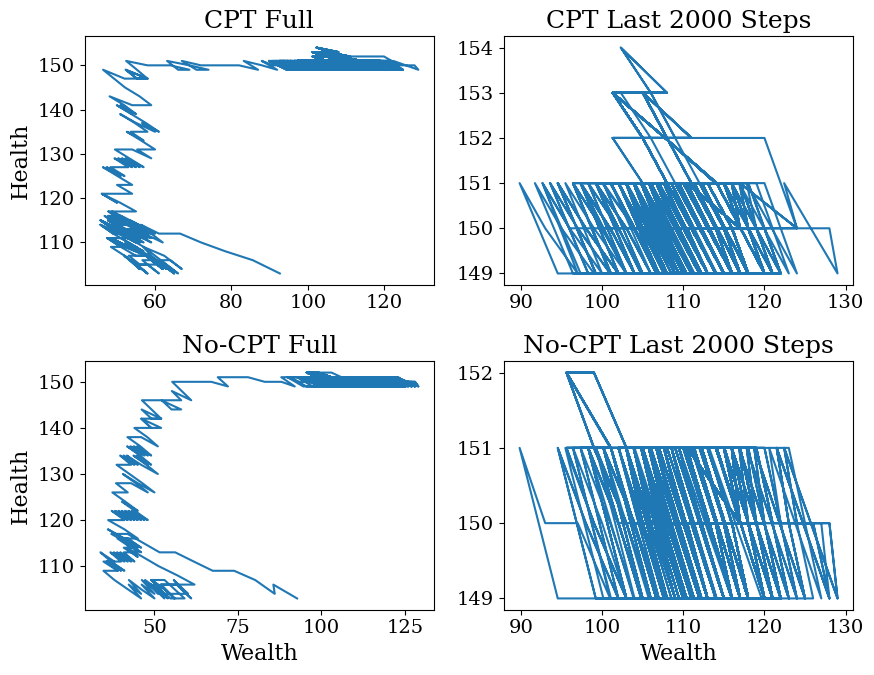

In [151]:
fig, axs = plt.subplots(2, 2, figsize=(9,7))

timesteps = [num_steps, 2000]

for j, t in enumerate(timesteps):
    for i, arr in enumerate([cpt_pos, nocpt_pos]):
        axs[i][j].plot(
            [x[0] for x in arr[-t:]],
            [x[1] for x in arr[-t:]],
        )

axs[0][0].set_ylabel("Health")
axs[1][0].set_ylabel("Health")
axs[1][0].set_xlabel("Wealth")
axs[1][1].set_xlabel("Wealth")

axs[0][0].set_title("CPT Full")
axs[0][1].set_title(f"CPT Last {timesteps[-1]} Steps")
axs[1][0].set_title("No-CPT Full")
axs[1][1].set_title(f"No-CPT Last {timesteps[-1]} Steps")

fig.tight_layout()
plt.show()

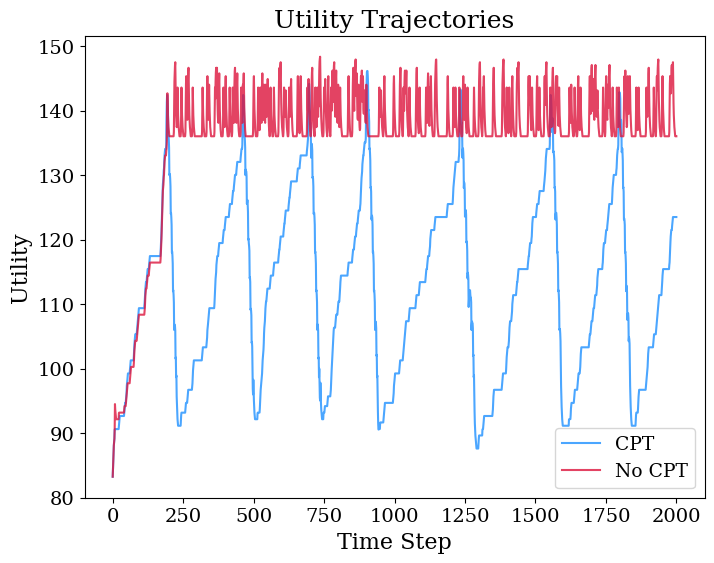

In [61]:
plt.plot(cpt_util, alpha=0.8, label="CPT", color="dodgerblue")
plt.plot(nocpt_util, alpha=0.8, label="No CPT", color="crimson")
plt.legend()
plt.title("Utility Trajectories")
plt.xlabel("Time Step")
plt.ylabel("Utility")
plt.show()